In [0]:
#downloading library
!pip install pytorch-nlp

In [0]:
"""Defining dataset extraction function"""
import os
import io

import json

from torchnlp.download import download_file_maybe_extract
from torchnlp.datasets.dataset import Dataset

def snli_dataset(directory='data/',
                 train=False,
                 dev=False,
                 test=False,
                 train_filename='snli_1.0_train.jsonl',
                 dev_filename='snli_1.0_dev.jsonl',
                 test_filename='snli_1.0_test.jsonl',
                 extracted_name='snli_1.0',
                 check_files=['snli_1.0/snli_1.0_train.jsonl'],
                 url='http://nlp.stanford.edu/projects/snli/snli_1.0.zip'):
    
    """Load the Stanford Natural Language Inference (SNLI) dataset.

    The SNLI corpus (version 1.0) is a collection of 570k human-written English sentence pairs
    manually labeled for balanced classification with the labels entailment, contradiction, and
    neutral, supporting the task of natural language inference (NLI), also known as recognizing
    textual entailment (RTE). We aim for it to serve both as a benchmark for evaluating
    representational systems for text, especially including those induced by representation
    learning methods, as well as a resource for developing NLP models of any kind.

    **Reference:** https://nlp.stanford.edu/projects/snli/

    Args:
        directory (str, optional): Directory to cache the dataset.
        train (bool, optional): If to load the training split of the dataset.
        dev (bool, optional): If to load the development split of the dataset.
        test (bool, optional): If to load the test split of the dataset.
        train_filename (str, optional): The filename of the training split.
        dev_filename (str, optional): The filename of the development split.
        test_filename (str, optional): The filename of the test split.
        extracted_name (str, optional): Name of the extracted dataset directory.
        check_files (str, optional): Check if these files exist, then this download was successful.
        url (str, optional): URL of the dataset `tar.gz` file.

    Returns:
        :class:`tuple` of :class:`torchnlp.datasets.Dataset` or :class:`torchnlp.datasets.Dataset`:
        Returns between one and all dataset splits (train, dev and test) depending on if their
        respective boolean argument is ``True``.

        }
    """
    download_file_maybe_extract(url=url, directory=directory, check_files=check_files)
    ret = []
    splits = [(train, train_filename), (dev, dev_filename), (test, test_filename)]
    splits = [f for (requested, f) in splits if requested]
    for filename in splits:
        full_path = os.path.join(directory, extracted_name, filename)
        examples = []
        with io.open(full_path, encoding='utf-8') as f:
            for line in f:
                line = line.strip()
                line = json.loads(line)
                examples.append({
                    'premise': line['sentence1'],
                    'hypothesis': line['sentence2'],
                    'label': line['gold_label']
                })
        ret.append(Dataset(examples))

    if len(ret) == 1:
        return ret[0]
    else:
        return tuple(ret)

In [0]:
#Obtaining dataset
train=snli_dataset(train=True) 

{'hypothesis': 'A team is trying to tag a runner out.',
 'label': 'entailment',
 'premise': 'A Little League team tries to catch a runner sliding into a base in an afternoon game.'}

In [0]:
#viewing training examples
train[36] 

{'hypothesis': 'The women do not care what clothes they wear.',
 'label': 'contradiction',
 'premise': 'High fashion ladies wait outside a tram beside a crowd of people in the city.'}

In [0]:
"""Importing required libraries"""
import os
import sys
import torch
import numpy as np
from PIL import Image
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import functional as F
from torch.nn.modules.padding import ConstantPad1d
from torch import topk 
from torchtext import data
from torchtext import datasets
from torchtext.vocab import Vectors, GloVe
# %matplotlib inline
from matplotlib.pyplot import imshow
from torchvision import models, transforms
import skimage.transform

In [0]:
"""Defining class CNN consisting of the model architecture to be used"""
class CNN(nn.Module):
    def __init__(self,vocab_size,embedding_length,weights):
        super(CNN, self).__init__()
        self.word_embeddings=nn.Embedding(vocab_size,embedding_length)
        self.word_embeddings.weight=nn.Parameter(weights,requires_grad=False)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=50, kernel_size=10, stride=2)
        self.pool = nn.AvgPool2d(kernel_size=1, stride=2)
        self.conv2 = nn.Conv2d(in_channels=50, out_channels=100, kernel_size=5, stride=2)
        self.AdapAvgPool=nn.AdaptiveAvgPool2d(((1,1)))
        self.fc1 = nn.Linear(in_features=100, out_features=3)
        
    def forward(self,input_sentences):
        x=self.word_embeddings(input_sentences)
        x=x.unsqueeze(1)
        x = self.pool(F.relu(self.conv1(x)))
        x =self.AdapAvgPool((F.relu(self.conv2(x))))
        x = x.view(-1, 1*1*100)
        x = self.fc1(x)
        return x

In [0]:
"""Function to load training and test dataset as iterators"""
def load_dataset(test_sen=None):
  tokenize=lambda x:x.split()
  Text=data.Field(sequential=True,tokenize=tokenize, lower=True, include_lengths=True,batch_first=True,fix_length=50)
  label=data.LabelField()
  train_data,valid_data,test_data=datasets.SNLI.splits(Text,label)
  Text.build_vocab(train_data,vectors=GloVe(name='6B',dim=100))
  label.build_vocab(train_data)
  
  word_embeddings=Text.vocab.vectors
  print("Length of text vocab"+str(len(Text.vocab)))
  print("Vector size of text vocab",Text.vocab.vectors.size())
  print("Label Length:"+str(len(label.vocab)))
  
  #train_data,valid_data=train_data.split()
  train_iter,valid_iter,test_iter=data.BucketIterator.splits((train_data,valid_data,test_data),batch_size=32,sort_key=lambda x:len(x.premise),repeat=False,shuffle=True)
  
  
  vocab_size=len(Text.vocab)
  
  return Text,vocab_size,word_embeddings,train_iter,valid_iter,test_iter

In [0]:
"""Loading dataset into variables"""
TEXT, vocab_size, word_embeddings, train_iter, valid_iter,test_iter = load_dataset()

downloading snli_1.0.zip


snli_1.0.zip: 100%|██████████| 94.6M/94.6M [00:19<00:00, 2.65MB/s]


extracting


.vector_cache/glove.6B.zip: 862MB [00:24, 35.0MB/s]                           
100%|█████████▉| 399454/400000 [00:16<00:00, 25212.34it/s]

Length of text vocab56220
Vector size of text vocab torch.Size([56220, 100])
Label Length:3


In [0]:
def clip_gradient(model,clip_value):
  params=list(filter(lambda p: p.grad is not None, model.parameters()))
  for p in params:
    p.grad.data.clamp(-clip_value,clip_value)

In [0]:
"""Function to train our model and output the accuracy"""
def train_model(model,train_iter,epoch):
  total_epoch_loss=0
  total_epoch_acc=0

  model.cuda()
  optim=torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()))
  steps=0
  model.train()
  for idx,batch in enumerate(train_iter):
    premise=batch.premise[0]
    hypothesis=batch.hypothesis[0]
    target=batch.label
    target=torch.autograd.Variable(target).long()
    if torch.cuda.is_available():
      premise=premise.cuda()
      hypothesis=hypothesis.cuda()
      target=target.cuda()   
#if (premise.size()[0] is not 50 or hypothesis.size()[0] is not 50):continue
    optim.zero_grad()
    joint=torch.cat([premise,hypothesis],1)
    prediction=model(joint)
    loss=loss_fn(prediction,target)
    num_corrects=(torch.max(prediction,1)[1].view(target.size()).data==target.data).float().sum()
    acc=100.0*num_corrects/len(batch)
    loss.backward()
    clip_gradient(model,1e-1)
    optim.step()
    steps+=1
    if steps%5000==0:
      print(f'Epoch: {epoch+1}, Idx: {idx+1}, Training Loss: {loss.item(): .4f}, Training Accuracy: {acc.item(): .2f}%')
    total_epoch_loss+=loss.item()
    total_epoch_acc+=acc.item()
  return total_epoch_loss/len(train_iter),total_epoch_acc/len(train_iter)



In [0]:
"""Function to evaluate our test set using our model and thus output the accuracy"""
def eval_model(model, val_iter):
  total_epoch_loss = 0
  total_epoch_acc = 0
  model.eval()
  with torch.no_grad():
      for idx, batch in enumerate(val_iter):
          premise=batch.premise[0]
          hypothesis=batch.hypothesis[0]
          if (premise.size()[0] is not 32 or hypothesis.size()[0] is not 32):
            continue
          target = batch.label
          target = torch.autograd.Variable(target).long()
          if torch.cuda.is_available():
              premise=premise.cuda()
              hypothesis=hypothesis.cuda()
              target = target.cuda()
          joint=torch.cat([premise,hypothesis],1)
          prediction=model(joint)
          loss = loss_fn(prediction, target)
          num_corrects = (torch.max(prediction, 1)[1].view(target.size()).data == target.data).sum()
          acc = 100.0 * num_corrects/len(batch)
          total_epoch_loss += loss.item()
          total_epoch_acc += acc.item()
  return total_epoch_loss/len(val_iter),total_epoch_acc/len(val_iter)

In [0]:
"""Saving our model into a variable and defining our loss function"""
model=CNN(vocab_size=56220,embedding_length=100,weights=word_embeddings)
loss_fn=F.cross_entropy

In [0]:
"""Running our training for X epochs and outputing test accuracy"""
for epoch in range(40):
  train_loss,train_acc=train_model(model,train_iter, epoch)
  val_loss,val_acc=eval_model(model,valid_iter)
  print(f'Epoch:{epoch+1:02},Train Loss:{train_loss:.3f},Train Acc:{train_acc:.2f}%,Val.Loss:{val_loss:3f},Val.Acc:{val_acc:.2f}%')
test_loss,test_acc=eval_model(model,test_iter)
print(f'Test Loss:{test_loss:.3f}, Test Acc: {test_acc:.2f}%')

Epoch: 1, Idx: 5000, Training Loss:  0.9385, Training Accuracy:  62.50%
Epoch: 1, Idx: 10000, Training Loss:  0.9065, Training Accuracy:  53.12%
Epoch: 1, Idx: 15000, Training Loss:  0.9735, Training Accuracy:  50.00%
Epoch:01,Train Loss:0.974,Train Acc:52.35%,Val.Loss:0.929620,Val.Acc:55.20%
Epoch: 2, Idx: 5000, Training Loss:  0.8988, Training Accuracy:  65.62%
Epoch: 2, Idx: 10000, Training Loss:  0.9410, Training Accuracy:  53.12%
Epoch: 2, Idx: 15000, Training Loss:  0.8425, Training Accuracy:  56.25%
Epoch:02,Train Loss:0.929,Train Acc:55.85%,Val.Loss:0.913131,Val.Acc:56.37%
Epoch: 3, Idx: 5000, Training Loss:  0.9418, Training Accuracy:  50.00%
Epoch: 3, Idx: 10000, Training Loss:  0.9478, Training Accuracy:  53.12%
Epoch: 3, Idx: 15000, Training Loss:  0.8961, Training Accuracy:  56.25%
Epoch:03,Train Loss:0.912,Train Acc:56.99%,Val.Loss:0.892832,Val.Acc:57.91%
Epoch: 4, Idx: 5000, Training Loss:  0.8263, Training Accuracy:  59.38%
Epoch: 4, Idx: 10000, Training Loss:  1.0725, 

In [0]:
''' Let us now predict the class on a single sentence just for the testing purpose. '''
test_sen1 = "Nobody goes to that restaurant."
test_sen2 = "It is too crowded."

test_sen1 = TEXT.preprocess(test_sen1)
test_sen1 = [[TEXT.vocab.stoi[x] for x in test_sen1]]

test_sen2 = TEXT.preprocess(test_sen2)
test_sen2 = [[TEXT.vocab.stoi[x] for x in test_sen2]]

premise_sen = np.asarray(test_sen1)
premise_sen = torch.LongTensor(premise_sen)
premise_tensor = Variable(premise_sen, volatile=True)
hypo_sen = np.asarray(test_sen2)
hypo_sen = torch.LongTensor(hypo_sen)
hypo_tensor = Variable(hypo_sen, volatile=True)
size1=premise_tensor[0].size()[0]
m=nn.ConstantPad1d((0,50-size1),1)
prem_tensor=m(premise_tensor)
size2=hypo_tensor[0].size()[0]
m=nn.ConstantPad1d((0,50-size2),1)
hyp_tensor=m(hypo_tensor)
test_tensor=torch.cat([prem_tensor,hyp_tensor],1)
test_tensor = test_tensor.cuda()
model.eval()
output = model(test_tensor)
out=F.softmax(output,1)
print(out)
if(torch.argmax(out[0])==0):
  print("Entailment")
elif(torch.argmax(out[0])==1):
  print("Contradiction")
else:
  print("Neutral")

tensor([[0.5776, 0.0649, 0.3576]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Entailment


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  app.launch_new_instance()


In [0]:
"""Viewing the architecture of our model"""
model.eval()

CNN(
  (word_embeddings): Embedding(56220, 100)
  (conv1): Conv2d(1, 50, kernel_size=(10, 10), stride=(2, 2))
  (pool): AvgPool2d(kernel_size=1, stride=2, padding=0)
  (conv2): Conv2d(50, 100, kernel_size=(5, 5), stride=(2, 2))
  (AdapAvgPool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=100, out_features=3, bias=True)
)

In [0]:
"""Creating a hook and saving particular layer features"""
class SaveFeatures():
  features=None
  def __init__(self,m):self.hook=m.register_forward_hook(self.hook_fn)
  def hook_fn(self,module,input,output): self.features=((output.cpu()).data).numpy()
  def remove(self): self.hook.remove()


In [0]:
"""Obtaining the layer needed"""
final_layer=model._modules.get('conv2')

In [0]:
"""Saving the feature of the layer needed"""
activated_features=SaveFeatures(final_layer)

In [0]:
"""Making the prediction and obtaining the layer features in that case"""
prediction=model(test_tensor)
pred_probabilities=F.softmax(prediction).data.squeeze()
activated_features.remove()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [0]:
topk(pred_probabilities,1)

torch.return_types.topk(values=tensor([0.8476], device='cuda:0'), indices=tensor([2], device='cuda:0'))

In [0]:
"""Obatining our final heatmap from the features by dot producting the weights and activation maps"""
def getCAM(feature_conv, weight_fc, class_idx):
  _,nc,h,w=feature_conv.shape
  cam=weight_fc[class_idx.cpu()].dot(feature_conv.reshape(((nc,h*w))))
  cam=cam.reshape(h,w)
  #cam=cam-np.min(cam)
  #cam_img=cam/np.max(cam)
  return [cam]

In [0]:
weight_softmax_params=list(model._modules.get('fc1').parameters())
weight_softmax=np.squeeze(weight_softmax_params[0].cpu().data.numpy())

In [0]:
activated_features.features.shape

(1, 100, 10, 10)

In [0]:
class_idx=topk(pred_probabilities,1)[1].int()

In [0]:
overlay=getCAM(activated_features.features, weight_softmax, class_idx)

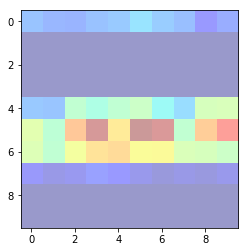

In [0]:
"""Plotting the map obtained"""
imshow(overlay[0], alpha=0.4, cmap='jet')

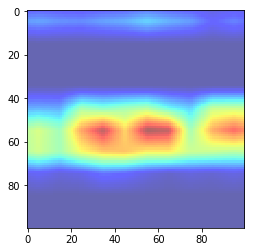

In [0]:
"""Plotting the similar heatmap resized to 100*100"""
imshow(skimage.transform.resize(overlay[0], [100,100]),alpha=0.6, cmap='jet')